In [2]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

In [3]:
import json
import os
import numpy as np
import itertools
from collections import Counter

from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns

import notebook_utils as nbu

In [4]:
tokenizer_dir = "../../../tokenizers"

languages = ('ar', 'zh', 'el', 'tr', 'es', 'en')
languages_old_order = ('ar', 'tr', 'zh','el', 'es', 'en')
multil_string = 'ar-tr-zh-el-es-en'

alphas = ('0.0', '0.25', '0.5', '0.75', '1.0')
# alphas_num = np.array([float(alpha) for alpha in alphas])
NV_multi = 120000
tok_type = "sp-unigram"

# load the statistics from monolingual corpora created using the multilingual tokenizer
token_stats = {}
for alpha in alphas:
    token_stats[alpha] = {}
    for lang in languages:
        tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-unigram", multil_string, f"alpha-{alpha}_N-120000", f"token_freq_{lang}_{alpha}.json")
        with open(tokenizer_stats_path) as f:
            token_stats[alpha][lang] = json.load(f)

# load the all-training-data multilingual tokenizer statistics
overall_token_stats = {}
for alpha in alphas:
    tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-unigram", multil_string, f"alpha-{alpha}_N-120000", f"token_frequencies.json")
    with open(tokenizer_stats_path) as f:
        overall_token_stats[alpha] = json.load(f)

In [5]:
# create the distributions for each alpha and language
def distribution_from_stats(stats, NV):
    dist = np.zeros(NV)
    assert len(stats) == NV
    for token, freq in stats.items():
        dist[int(token)] = freq
    dist /= dist.sum()
    return dist

token_dists = {}
overall_token_dists = {}
for alpha in alphas:
    token_dists[alpha] = {}
    for lang in languages:
        token_dists[alpha][lang] = distribution_from_stats(token_stats[alpha][lang], NV_multi)
    
    overall_token_dists[alpha] = distribution_from_stats(overall_token_stats[alpha], NV_multi)

In [6]:
len(overall_token_dists['0.0'])

120000

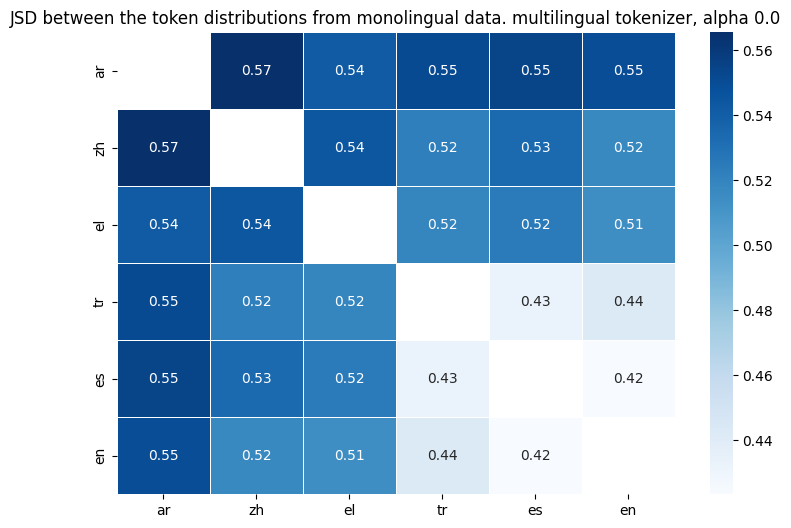

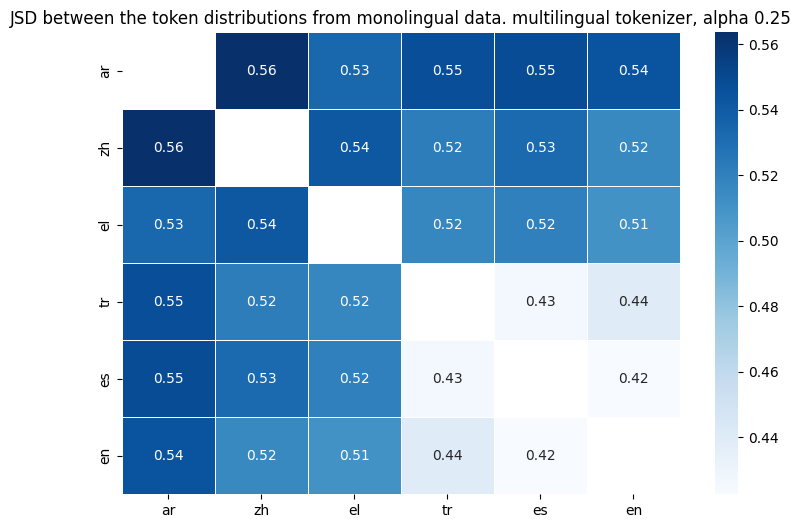

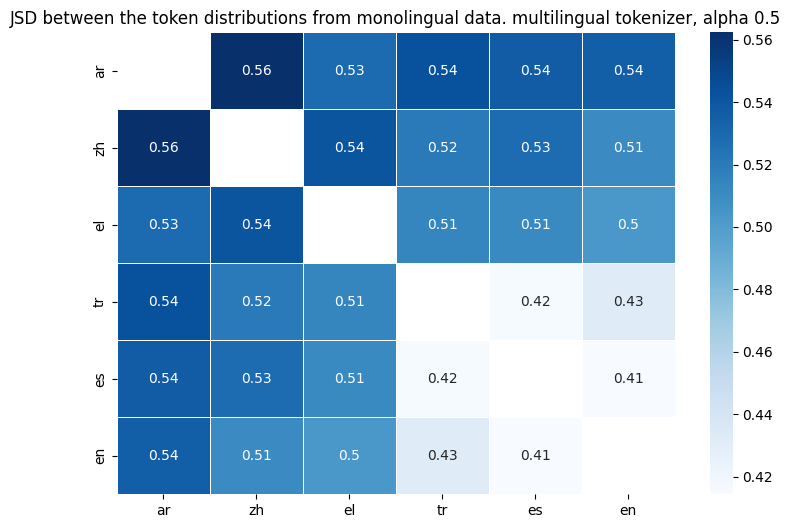

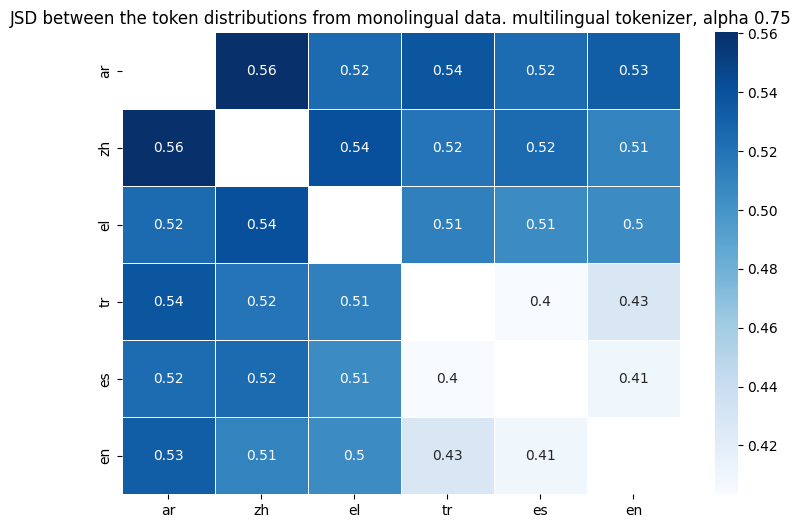

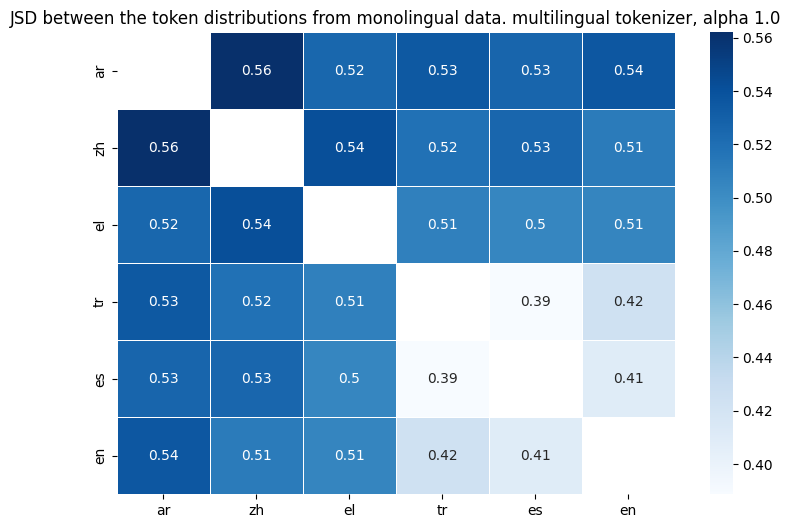

In [7]:
# compute the Jensen–Shannon divergence between the distributions
from scipy.spatial.distance import jensenshannon

jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1, lang2 in itertools.product(languages, languages):
        # to get the divergence, we need to square the JS-distances
        jds[alpha][(lang1, lang2)] = jensenshannon(token_dists[alpha][lang1], token_dists[alpha][lang2]) ** 2

# plot the KL divergence as a heatmap
for alpha in alphas:
    # plt.figure(figsize=(10, 10))
    divergences = np.array([[jds[alpha][(lang1, lang2)] for lang1 in languages] for lang2 in languages])

    f, ax = plt.subplots(figsize=(9, 6))
    # mask = np.zeros_like(divergences, dtype=np.bool)
    mask = np.eye(divergences.shape[0], dtype='bool')
    sns.heatmap(divergences, mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues")

    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"JSD between the token distributions from monolingual data. multilingual tokenizer, alpha {alpha}")
    plt.show()

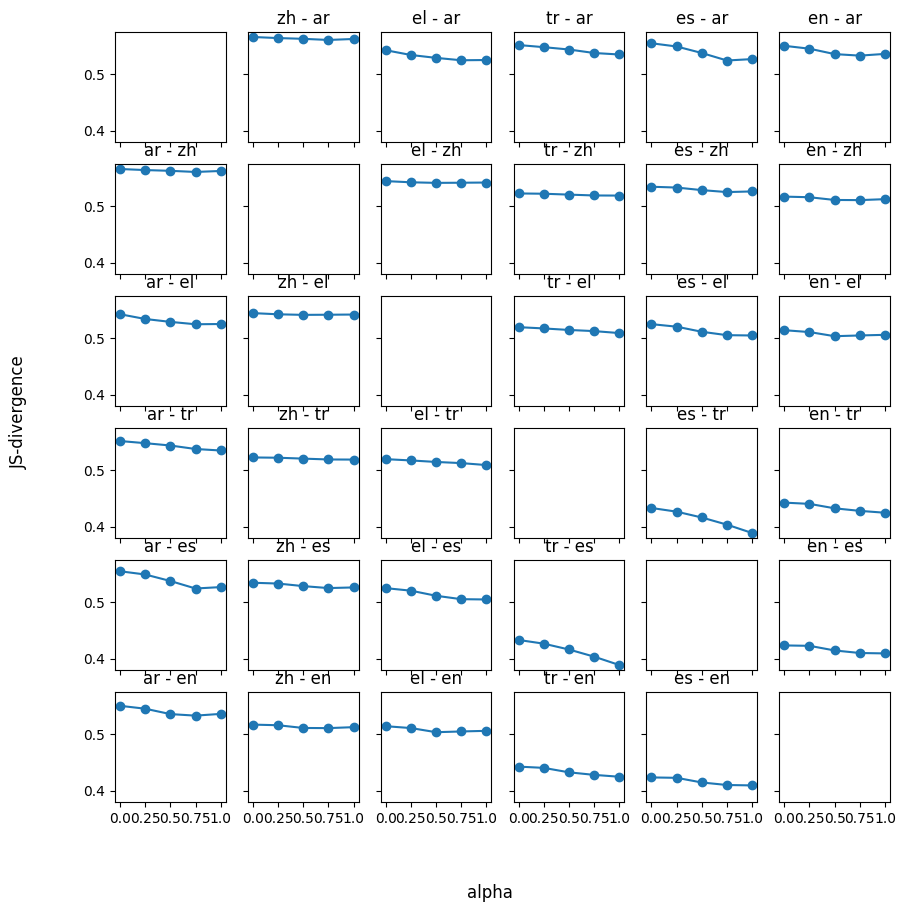

In [8]:
# plot the JS divergence as a grid of plots (one for each language pair) with x = alpha and y = divergence
fig, axes = plt.subplots(len(languages), len(languages), figsize=(10, 10), sharex=True, sharey=True)
for lang1, lang2 in itertools.product(languages, languages):
    if lang1 == lang2:
        continue
    ax = axes[languages.index(lang2), languages.index(lang1)]
    ax.plot(alphas, [jds[alpha][(lang1, lang2)] for alpha in alphas], marker='o')
    ax.set_title(f"{lang1} - {lang2}")
    # ax.set_xlabel("alpha")
    # ax.set_ylabel("JS-divergence")
fig.supxlabel("alpha")
fig.supylabel("JS-divergence")
plt.show()

- observation: the divergences never go higher with more data


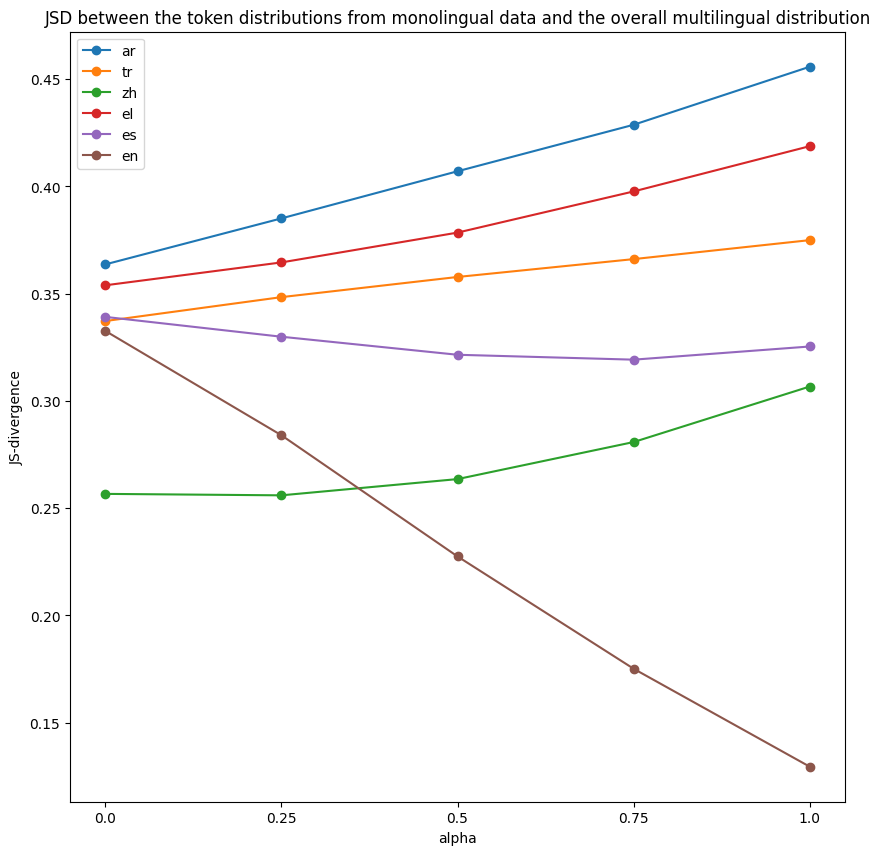

In [9]:
# compute the Jensen–Shannon divergence between the monolingual distributions and the overall distribution
jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1 in languages:
        jds[alpha][lang1] = jensenshannon(token_dists[alpha][lang1], overall_token_dists[alpha]) ** 2

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([jds[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([jds[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("JS-divergence")
plt.title("JSD between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

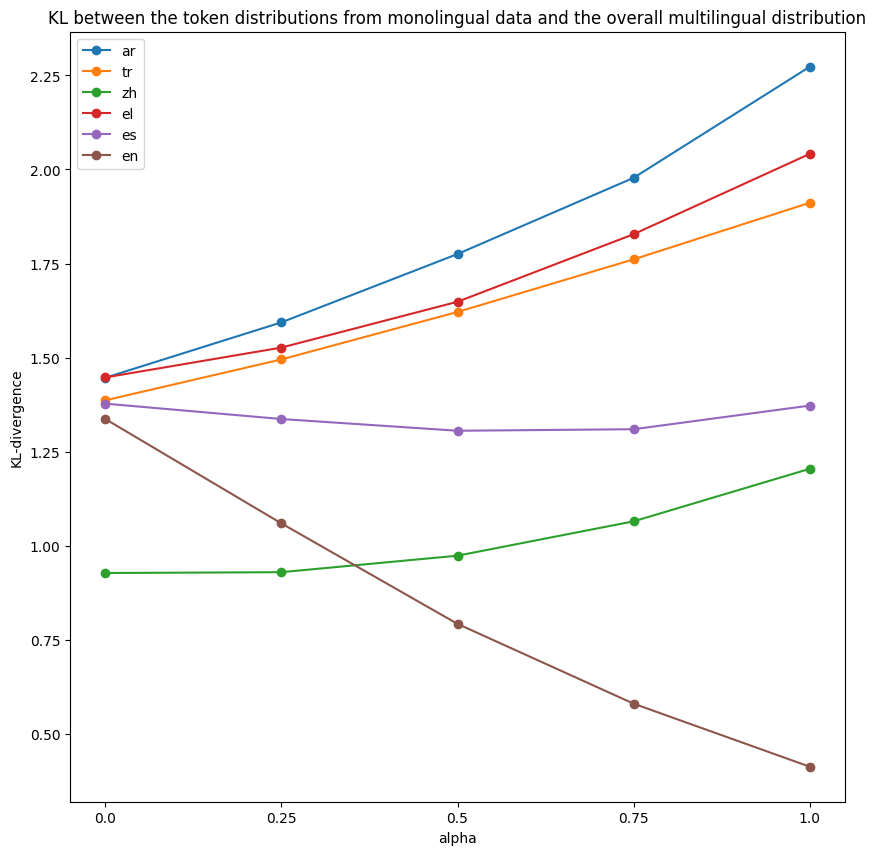

In [10]:
# compute the KL divergence between the monolingual distributions and the overall distribution
from scipy.stats import entropy

kls = {}
for alpha in alphas:
    kls[alpha] = {}
    for lang1 in languages:
        kls[alpha][lang1] = entropy(token_dists[alpha][lang1], overall_token_dists[alpha])

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([kls[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([kls[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("KL-divergence")
plt.title("KL between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

## Tokenizer profile plot PDFs

<Figure size 640x480 with 0 Axes>

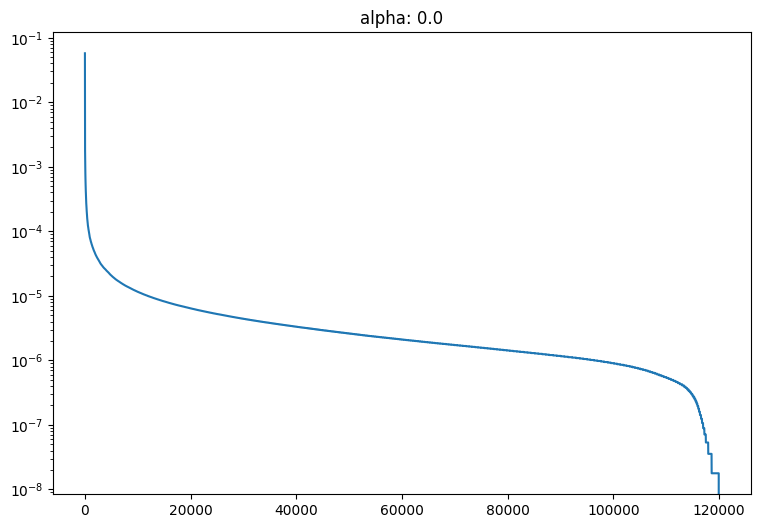

<Figure size 640x480 with 0 Axes>

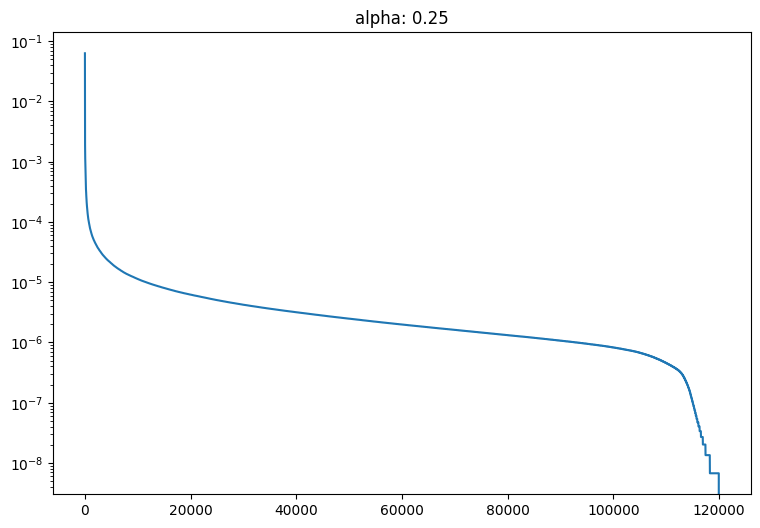

<Figure size 640x480 with 0 Axes>

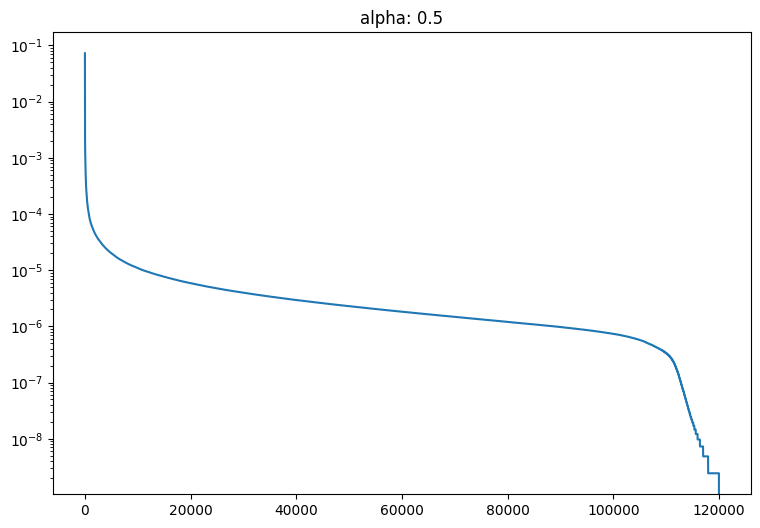

<Figure size 640x480 with 0 Axes>

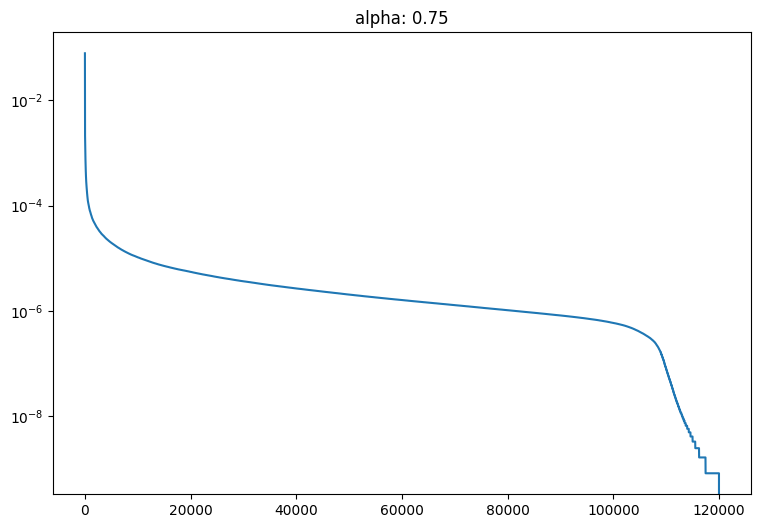

<Figure size 640x480 with 0 Axes>

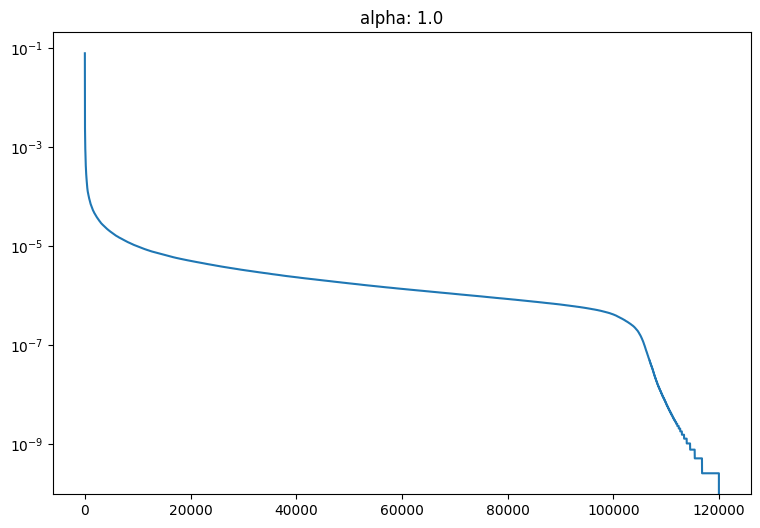

In [11]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    sorted_data = np.sort(overall_token_dists[alpha])[::-1]
    ax.plot(sorted_data)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    plt.show()


# For each language

<Figure size 640x480 with 0 Axes>

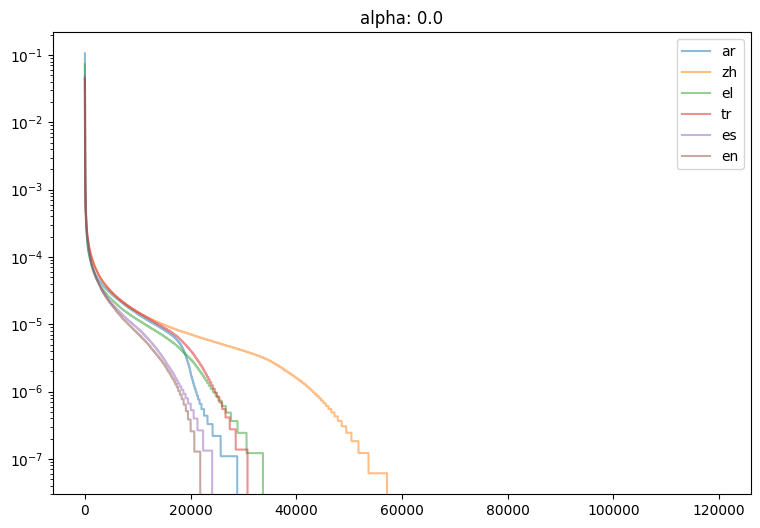

<Figure size 640x480 with 0 Axes>

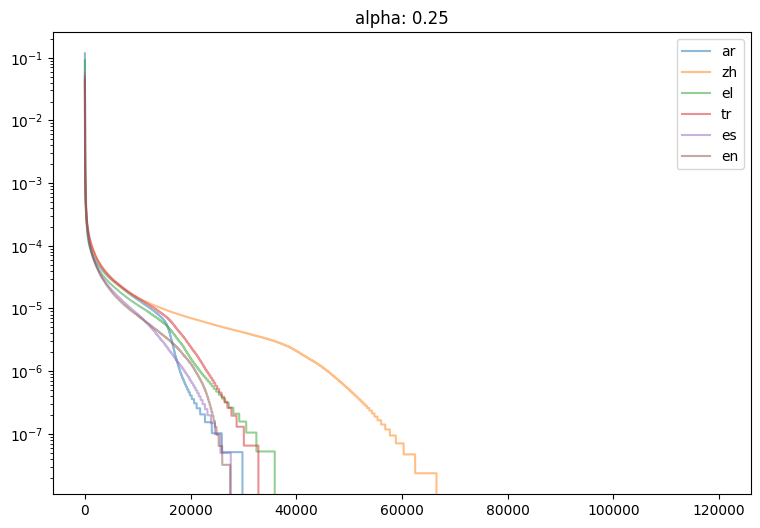

<Figure size 640x480 with 0 Axes>

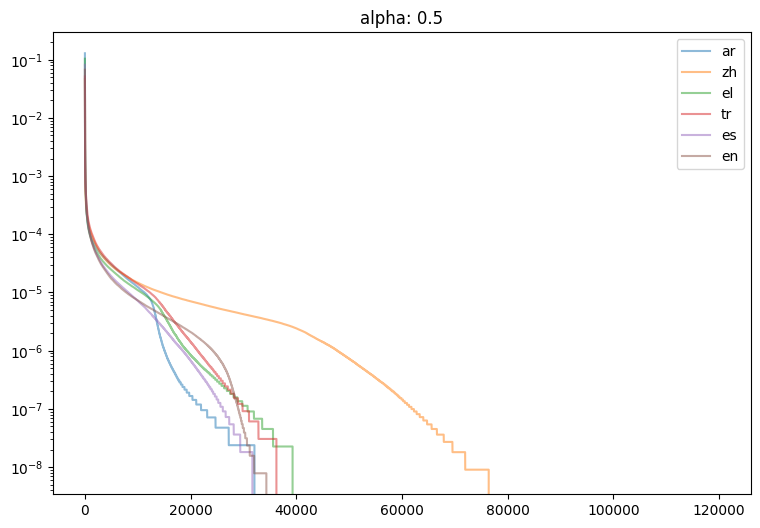

<Figure size 640x480 with 0 Axes>

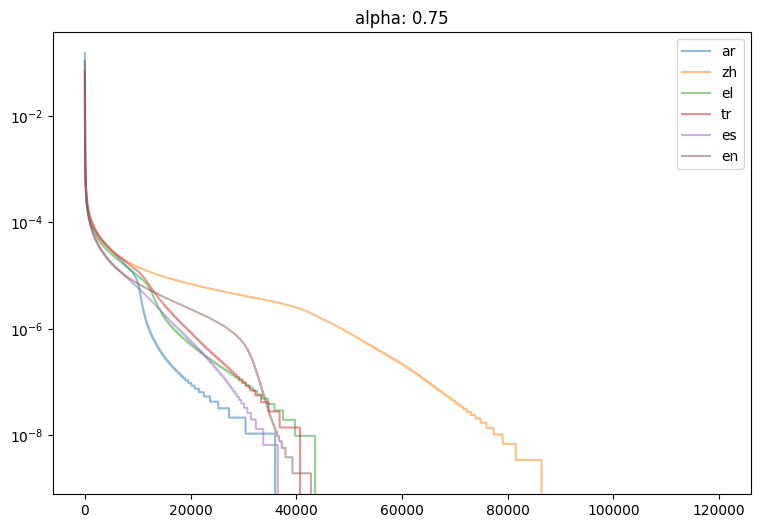

<Figure size 640x480 with 0 Axes>

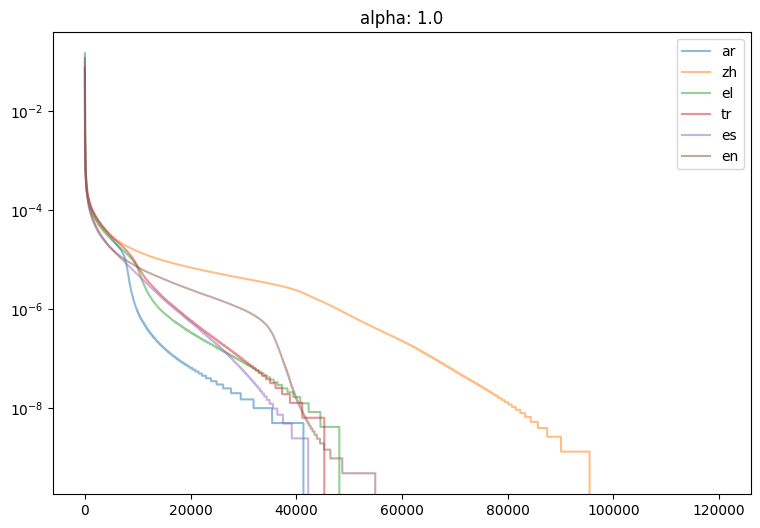

In [12]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    percentile_idx = {}
    for lang in languages:
        sorted_data = np.sort(token_dists[alpha][lang])[::-1]
        ax.plot(sorted_data, label=lang, alpha=0.5)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    ax.legend()
    plt.show()

        

<Figure size 640x480 with 0 Axes>

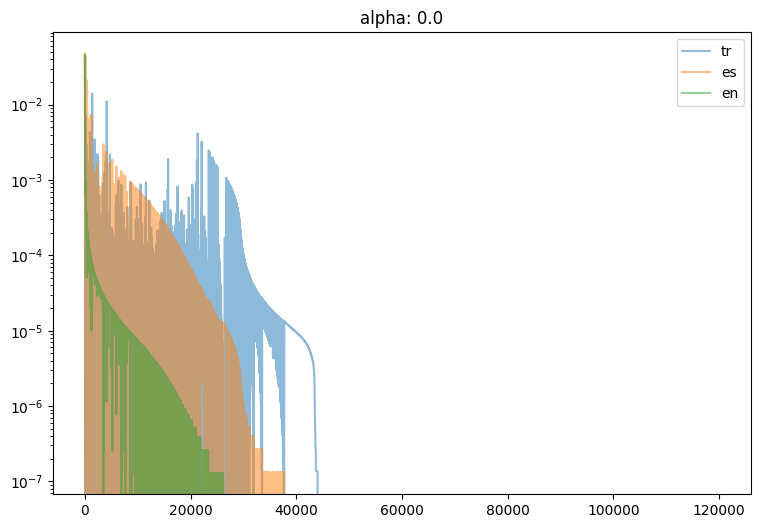

<Figure size 640x480 with 0 Axes>

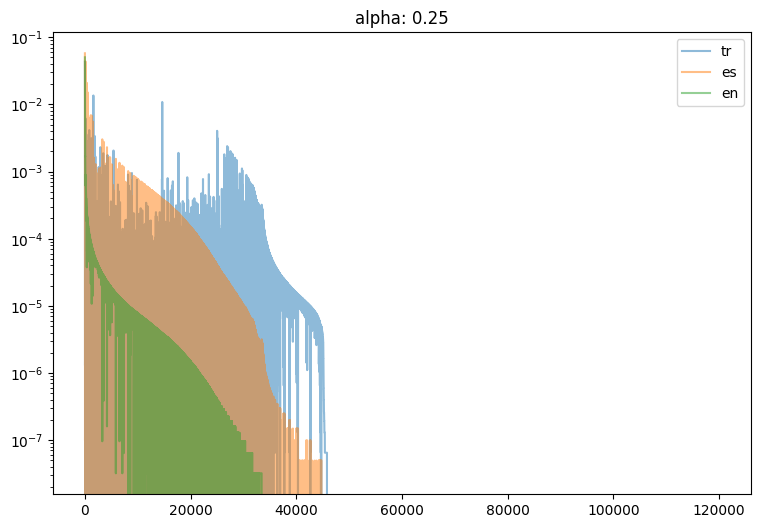

<Figure size 640x480 with 0 Axes>

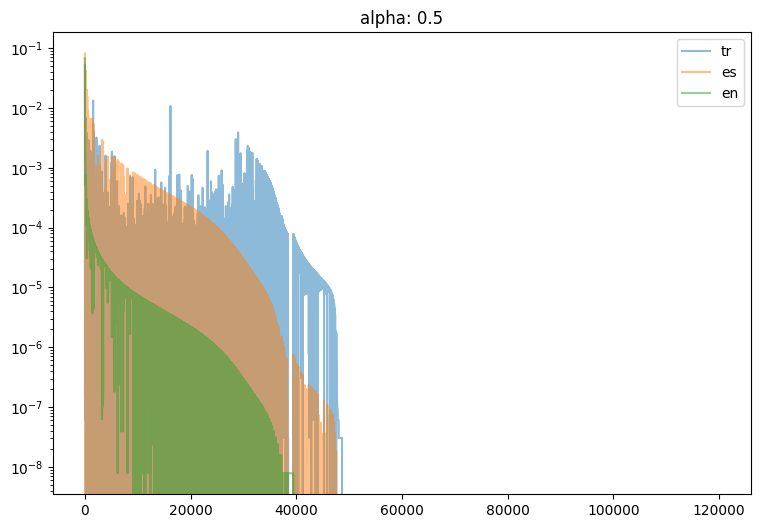

<Figure size 640x480 with 0 Axes>

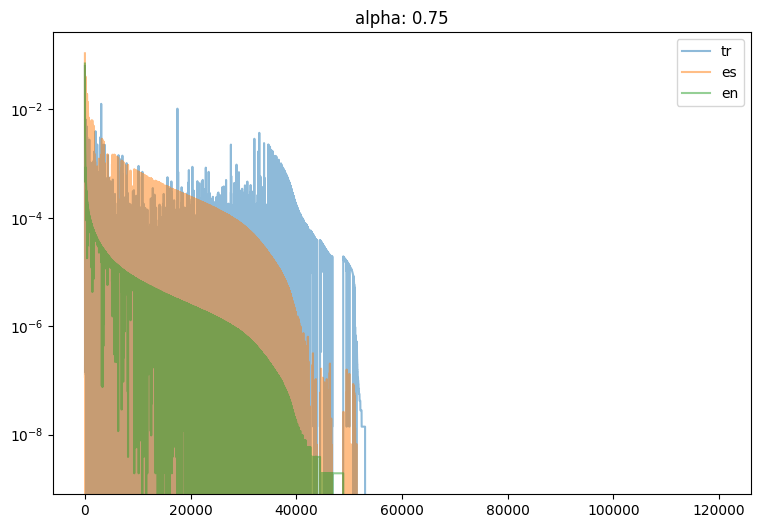

<Figure size 640x480 with 0 Axes>

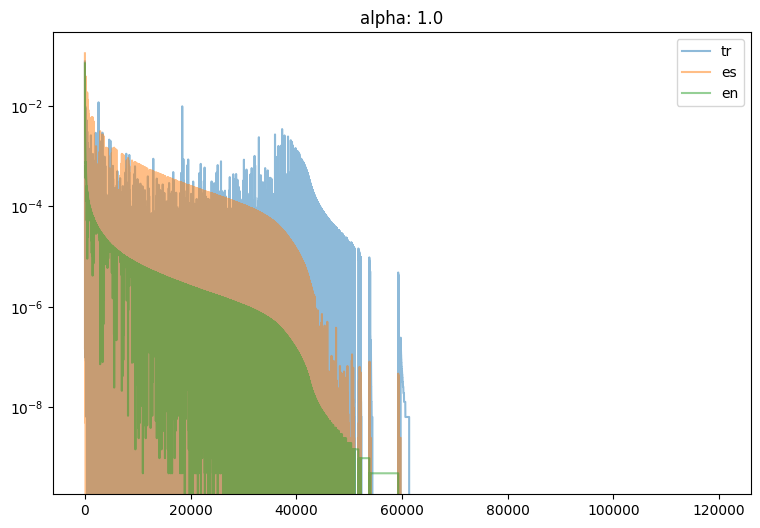

In [13]:
langugage_subset = ('tr','es', 'en')
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    index_sort_key = np.zeros_like(overall_token_dists[alpha])
    for lang_idx, lang in enumerate(langugage_subset):
        index_sort_key -= token_dists[alpha][lang] * pow(100, lang_idx)
    index_sort = np.argsort(index_sort_key)
    for lang in langugage_subset:
        ax.plot(token_dists[alpha][lang][index_sort], label=lang, alpha=0.5)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    ax.legend()


# CDFs

<Figure size 640x480 with 0 Axes>

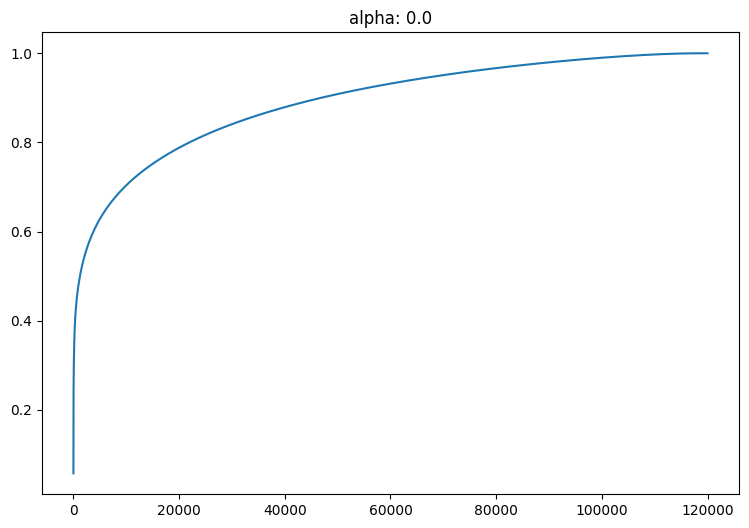

quatniles: 0.90, 0.95, 0.99, 0.999: [46847, 69429, 99989, 113519]
average rank: 13010


<Figure size 640x480 with 0 Axes>

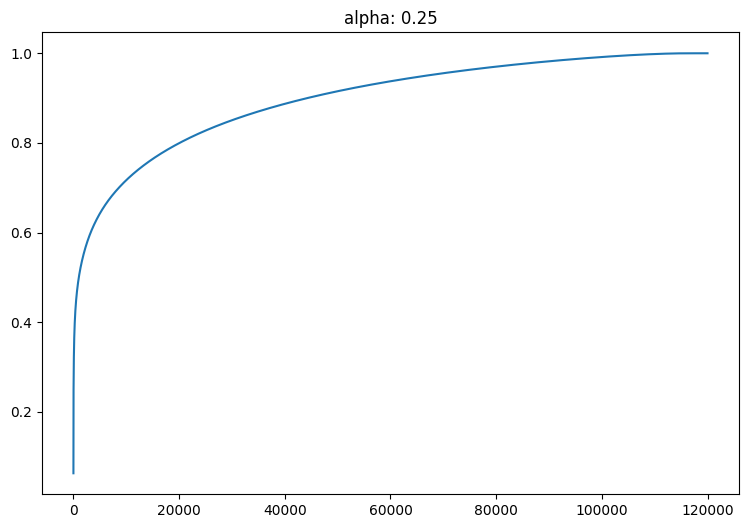

quatniles: 0.90, 0.95, 0.99, 0.999: [44235, 66695, 98024, 111638]
average rank: 12253


<Figure size 640x480 with 0 Axes>

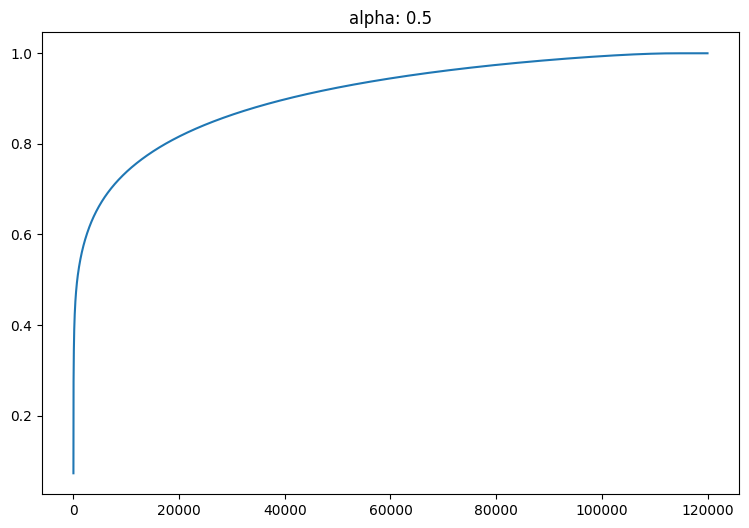

quatniles: 0.90, 0.95, 0.99, 0.999: [40594, 63072, 95363, 109325]
average rank: 11200


<Figure size 640x480 with 0 Axes>

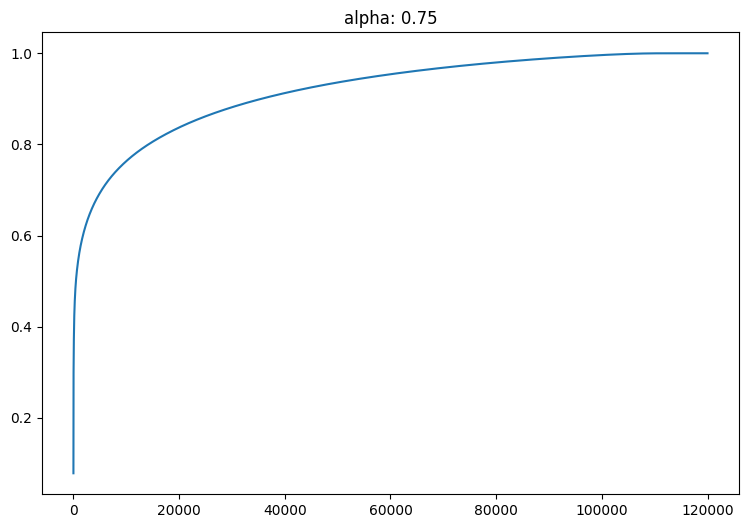

quatniles: 0.90, 0.95, 0.99, 0.999: [35530, 57559, 91238, 106082]
average rank: 9856


<Figure size 640x480 with 0 Axes>

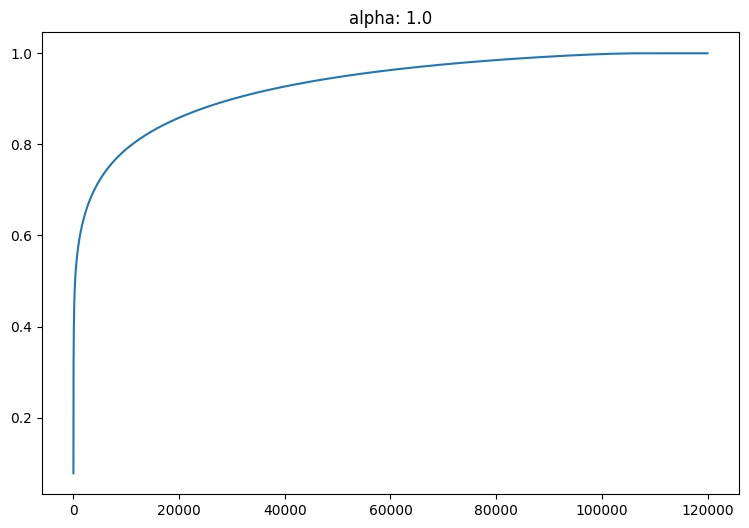

quatniles: 0.90, 0.95, 0.99, 0.999: [30219, 51371, 86145, 102081]
average rank: 8517


In [25]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    sorted_data = np.sort(overall_token_dists[alpha])[::-1]
    ax.plot(np.cumsum(sorted_data))

    ax.set_title(f"alpha: {alpha}")
    plt.show()



    percentile_idx = [ np.abs(np.cumsum(sorted_data) - perc).argmin() for perc in (0.9, 0.95, 0.99, 0.999)]
    avg_rang = np.sum(sorted_data * np.arange(len(sorted_data)))
    print(f"quatniles: 0.90, 0.95, 0.99, 0.999: {percentile_idx}")
    print(f"average rank: {np.round(avg_rang):.0f}")

<Figure size 640x480 with 0 Axes>

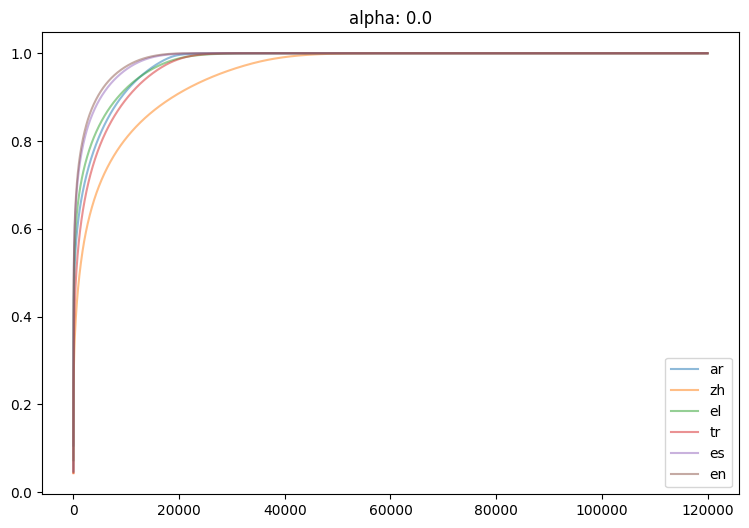

ar percentiles: 0.90, 0.95, 0.99, 0.999: [9059, 12960, 18162, 23178]
ar average rang: 2513
zh percentiles: 0.90, 0.95, 0.99, 0.999: [18770, 27036, 39206, 49215]
zh average rang: 5560
el percentiles: 0.90, 0.95, 0.99, 0.999: [8418, 13020, 20576, 28311]
el average rang: 2327
tr percentiles: 0.90, 0.95, 0.99, 0.999: [10279, 14511, 20839, 26500]
tr average rang: 3008
es percentiles: 0.90, 0.95, 0.99, 0.999: [5207, 8626, 14644, 20187]
es average rang: 1476
en percentiles: 0.90, 0.95, 0.99, 0.999: [4522, 7738, 13815, 18661]
en average rang: 1324


<Figure size 640x480 with 0 Axes>

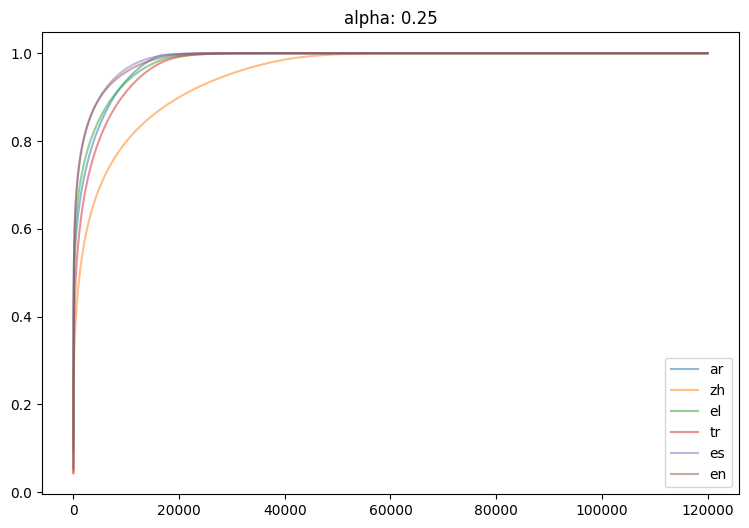

ar percentiles: 0.90, 0.95, 0.99, 0.999: [7653, 10925, 15387, 20962]
ar average rang: 2129
zh percentiles: 0.90, 0.95, 0.99, 0.999: [20022, 29042, 42369, 54061]
zh average rang: 5919
el percentiles: 0.90, 0.95, 0.99, 0.999: [7426, 11475, 18298, 27410]
el average rang: 2070
tr percentiles: 0.90, 0.95, 0.99, 0.999: [9176, 13015, 19281, 26198]
tr average rang: 2719
es percentiles: 0.90, 0.95, 0.99, 0.999: [4990, 8390, 14823, 21446]
es average rang: 1439
en percentiles: 0.90, 0.95, 0.99, 0.999: [5074, 9037, 16578, 22252]
en average rang: 1513


<Figure size 640x480 with 0 Axes>

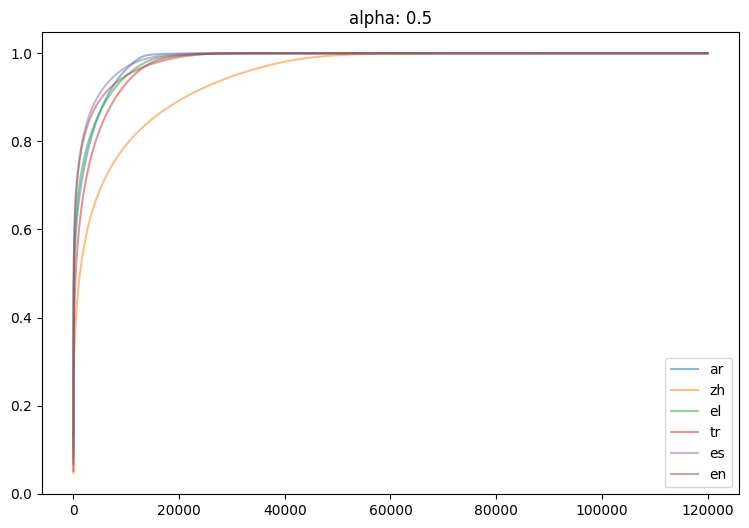

ar percentiles: 0.90, 0.95, 0.99, 0.999: [6284, 8958, 12657, 18621]
ar average rang: 1759
zh percentiles: 0.90, 0.95, 0.99, 0.999: [21075, 30590, 44779, 58364]
zh average rang: 6213
el percentiles: 0.90, 0.95, 0.99, 0.999: [6575, 10116, 16084, 26792]
el average rang: 1843
tr percentiles: 0.90, 0.95, 0.99, 0.999: [8025, 11417, 17604, 26153]
tr average rang: 2407
es percentiles: 0.90, 0.95, 0.99, 0.999: [4546, 7866, 14567, 22324]
es average rang: 1339
en percentiles: 0.90, 0.95, 0.99, 0.999: [5366, 10072, 19489, 26146]
en average rang: 1648


<Figure size 640x480 with 0 Axes>

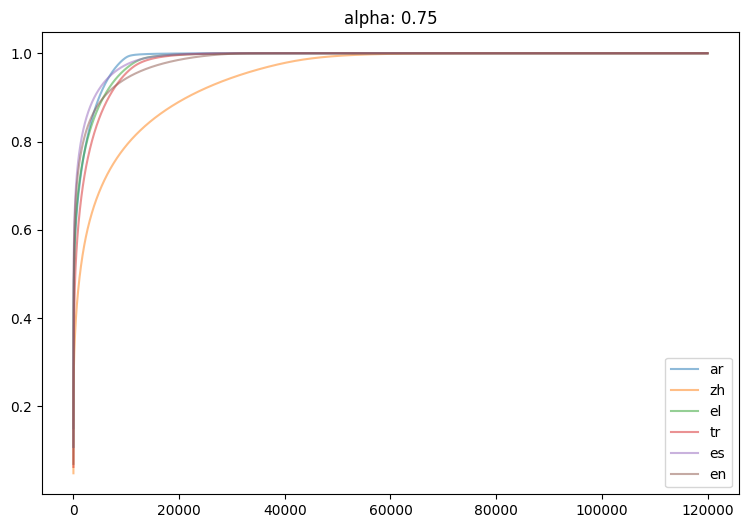

ar percentiles: 0.90, 0.95, 0.99, 0.999: [4855, 6923, 9894, 16437]
ar average rang: 1371
zh percentiles: 0.90, 0.95, 0.99, 0.999: [21452, 31318, 46209, 61694]
zh average rang: 6326
el percentiles: 0.90, 0.95, 0.99, 0.999: [5672, 8604, 13814, 26240]
el average rang: 1620
tr percentiles: 0.90, 0.95, 0.99, 0.999: [6675, 9582, 15766, 26195]
tr average rang: 2036
es percentiles: 0.90, 0.95, 0.99, 0.999: [3953, 7051, 13948, 23000]
es average rang: 1207
en percentiles: 0.90, 0.95, 0.99, 0.999: [5697, 11016, 22301, 30100]
en average rang: 1790


<Figure size 640x480 with 0 Axes>

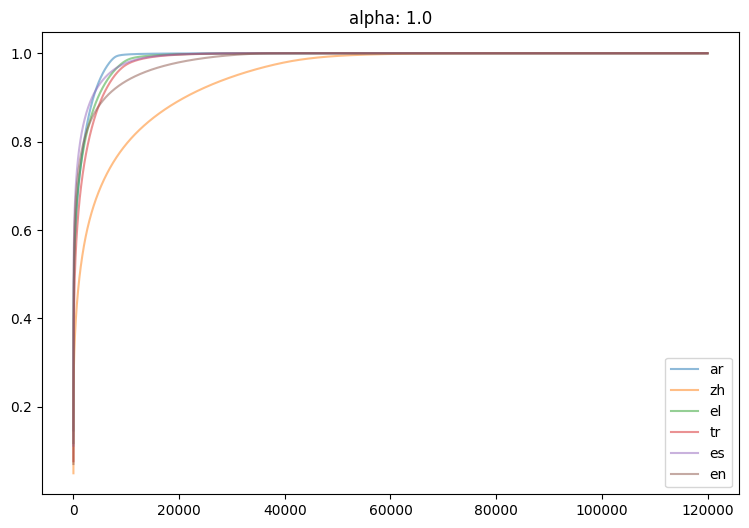

ar percentiles: 0.90, 0.95, 0.99, 0.999: [3780, 5358, 7700, 14728]
ar average rang: 1101
zh percentiles: 0.90, 0.95, 0.99, 0.999: [21047, 30815, 45923, 63297]
zh average rang: 6222
el percentiles: 0.90, 0.95, 0.99, 0.999: [4643, 7007, 11474, 25630]
el average rang: 1365
tr percentiles: 0.90, 0.95, 0.99, 0.999: [5430, 7833, 14067, 26036]
tr average rang: 1695
es percentiles: 0.90, 0.95, 0.99, 0.999: [3526, 6373, 13462, 23867]
es average rang: 1115
en percentiles: 0.90, 0.95, 0.99, 0.999: [6082, 12043, 25288, 34284]
en average rang: 1953


In [28]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    percentile_idx = {}
    avg_rangs = {}
    for lang in languages:
        sorted_data = np.sort(token_dists[alpha][lang])[::-1]
        ax.plot(np.cumsum(sorted_data), label=lang, alpha=0.5)
        percentile_idx[lang] = [ np.abs(np.cumsum(sorted_data) - perc).argmin() for perc in (0.9, 0.95, 0.99, 0.999)]
        avg_rangs[lang] = np.sum(sorted_data * np.arange(len(sorted_data)))
    ax.set_title(f"alpha: {alpha}")
    ax.legend()
    plt.show()
    for lang in languages:
        print(f"{lang} percentiles: 0.90, 0.95, 0.99, 0.999: {percentile_idx[lang]}")
        print(f"{lang} average rang: {np.round(avg_rangs[lang]):.0f}")
        